## Combine specific plates of profiles together to form analytical datasets

In image-based profiling, we collect data on a per-plate basis.
This means that to increase sample size of cell lines and treatments, we often need to collect data from multiple plates.

We collected many different plates in this experiment, and many of these plates contained different cell line clones and different treatments.
In this notebook, we combine the following plates and batches to form three complete datasets to perform downstream analysis.

The datasets are:

1. cloneAE (bortezomib)
2. ixazomib (no treatment and treatment)
3. CB-5083 (no treatment and treatment)

### Datasets by plate

| Plate | Number of Profiles | Batch | Dataset | 
| :---- | :----------------- | :---- | :------ | 
| 218363 | 60 | 2020_07_02_Batch8 | cloneAE |
| 218362 | 60 | 2020_07_02_Batch8 | cloneAE |
| 218361 | 60 | 2020_07_02_Batch8 | cloneAE |
| 218360 | 60 | 2020_07_02_Batch8 | cloneAE |
| 218361 | 60 | 2020_07_02_Batch8 | cloneAE |
| 218360 | 60 | 2020_07_02_Batch8 | cloneAE |
| HCT116bortezomib | 36 | 2019_02_15_Batch1_20X | cloneAE_validation |
| 207106_exposure320 | 36 | 2019_03_20_Batch2 | cloneAE_validation |
| 218858 | 60 | 2020_09_08_Batch10 | ixazomib_no_trt |
| 218854 | 60 | 2020_09_08_Batch10 | ixazomib_no_trt |
| 218698 | 60 | 2020_08_24_Batch9 | ixazomib_no_trt_validation |
| 218859 | 60 | 2020_09_08_Batch10 | ixazomib_trt |
| 218855 | 60 | 2020_09_08_Batch10 | ixazomib_trt |
| 218699 | 60 | 2020_08_24_Batch9 | ixazomib_trt_validation |
| 218856 | 60 | 2020_09_08_Batch10 | cb5083_no_trt |
| 218852 | 60 | 2020_09_08_Batch10 | cb5083_no_trt |
| 218774 | 60 | 2020_08_24_Batch9 | cb5083_no_trt_validation |
| 218696 | 60 | 2020_08_24_Batch9 | cb5083_no_trt_validation |
| 218857 | 60 | 2020_09_08_Batch10 | cb5083_trt |
| 218853 | 60 | 2020_09_08_Batch10 | cb5083_trt |
| 218775 | 60 | 2020_08_24_Batch9 | cb5083_trt_validation |
| 218697 | 60 | 2020_08_24_Batch9 | cb5083_trt_validation |

Note that for the cb5083 and ixazomib datasets, we only compile untreated plates.
See https://github.com/broadinstitute/profiling-resistance-mechanisms/issues/89 for more details.

We specifically selected validation sets that were collected on an entirely different plate.
No info from this plate was included in training or testing.

| Plate | Dataset | Batch |
| :--- | :----- | :--------------: |
| 218360 | cloneAE | 2020_07_02_Batch8 |
| 218858 | ixazomib | 2020_09_08_Batch10 |
| 218774 | cb5083 | 2020_08_24_Batch9 |


### Other enhancements

In this notebook, I also perform several other operations to prepare the data for downstream analyses:

* Add columns `Metadata_unique_sample_name`, `Metadata_clone_type`, and `Metadata_clone_type_indicator` to all profiles.
  * These columns determine if the clone that was passaged was resistant or senstive to the given drug and will help with identification later.
* Perform feature selection within each dataset.
  * I save the outcome of feature selection in a separate table ("dataset_features_selected.tsv")
* I output the combined and processed datasets to two files:
  * Dataset-specific compressed CSV files (no feature selection)
  * Dataset-specific .gct files (with feature selection)

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from pycytominer import feature_select
from pycytominer.cyto_utils import infer_cp_features, write_gct

sys.path.insert(0, "../2.describe-data/scripts")
from processing_utils import load_data

In [2]:
np.random.seed(1233)

In [3]:
data_dir = pathlib.Path("../0.generate-profiles/profiles")
cell_count_dir = pathlib.Path("../0.generate-profiles/cell_counts/")

output_dir = pathlib.Path("data")

profile_suffix = "normalized.csv.gz"

feature_select_opts = [
    "variance_threshold",
    "correlation_threshold",
    "drop_na_columns",
    "blocklist",
    "drop_outliers",
]

test_set_size = 0.25
corr_threshold = 0.90
na_cutoff = 0

In [4]:
datasets = {
    "cloneAE": {
        "2019_02_15_Batch1_20X": ["HCT116bortezomib"],
        "2019_03_20_Batch2": ["207106_exposure320"],
        "2020_07_02_Batch8": ["218360", "218361"],
    },
    "ixazomib": {
        "2020_08_24_Batch9": ["218698"],
        "2020_09_08_Batch10": ["218854", "218858"]
    },
    "cb5083": {
        "2020_08_24_Batch9": ["218774", "218696"],
        "2020_09_08_Batch10": ["218852", "218856"]
    }
}

# The rest of the plates belong to part of the training set
validation_plates = {
    "cloneAE": "218360",
    "ixazomib": "218858",
    "cb5083": "218774"
}

In [5]:
# Load and concatenate profiles into a single file
all_datasets_df = []
for dataset in datasets:
    dataset_df = []
    validation_plate = validation_plates[dataset]
    for batch in datasets[dataset]:
        plates = datasets[dataset][batch]

        # Load and harmonize data for the given plates
        df = load_data(
            batch=batch,
            plates=plates,
            profile_dir=data_dir,
            suffix=profile_suffix,
            combine_dfs=True,
            harmonize_cols=True,
            add_cell_count=True,
            cell_count_dir=cell_count_dir
        )
        
        # Add important metadata features
        df = df.assign(
            Metadata_dataset=dataset,
            Metadata_batch=batch,
            Metadata_clone_type="resistant",
            Metadata_clone_type_indicator=1,
            Metadata_model_split="training"
        )

        df.loc[df.Metadata_clone_number.str.contains("WT"), "Metadata_clone_type"] = "sensitive"
        df.loc[df.Metadata_clone_number.str.contains("WT"), "Metadata_clone_type_indicator"] = 0
        dataset_df.append(df)
        
    # Merge plates of the same dataset together
    dataset_df = pd.concat(dataset_df, axis="rows", sort=False).reset_index(drop=True)
    
    # Generate a unique sample ID
    # (This will be used in singscore calculation)
    dataset_df = dataset_df.assign(
        Metadata_unique_sample_name=[f"profile_{x}_{dataset}" for x in range(0, dataset_df.shape[0])]
    )
    
    # Determine training/test/validation splits
    if dataset != "cloneAE":
        dataset_df.loc[
            dataset_df.Metadata_clone_number.astype(str) == "WT_parental", "Metadata_model_split"
        ] = "test"
        
    dataset_df.loc[
        dataset_df.Metadata_Plate.astype(str) == validation_plate, "Metadata_model_split"
    ] = "validation"
    
    training_df = (
        dataset_df
        .query("Metadata_model_split == 'training'")
        .query("Metadata_treatment == '0.1% DMSO'")
    )
    
    if dataset != "cloneAE":
        training_df = training_df.query("Metadata_clone_number != 'WT_parental'")

    train_samples, test_samples = train_test_split(
        training_df.Metadata_unique_sample_name,
        random_state=9876,
        test_size=test_set_size,
        stratify=training_df.Metadata_clone_number.astype(str)
    )

    dataset_df.loc[
        dataset_df.Metadata_unique_sample_name.isin(test_samples), "Metadata_model_split"
    ] = "test"
    dataset_df.loc[
        dataset_df.Metadata_treatment != '0.1% DMSO', "Metadata_model_split"
    ] = "perturbation"

    all_datasets_df.append(dataset_df)

all_datasets_df = pd.concat(all_datasets_df, axis="rows", sort=False).reset_index(drop=True)

In [6]:
# Remember, we are not training with WT_parental lines
pd.crosstab(all_datasets_df.Metadata_dataset, all_datasets_df.Metadata_model_split)

Metadata_model_split,perturbation,test,training,validation
Metadata_dataset,,,,
cb5083,0,59,121,60
cloneAE,144,9,24,15
ixazomib,0,39,81,60


In [7]:
pd.crosstab(all_datasets_df.Metadata_clone_number, all_datasets_df.Metadata_model_split)

Metadata_model_split,perturbation,test,training,validation
Metadata_clone_number,,,,
CB5038 clone 13,0,5,13,6
CB5038 clone 14,0,4,14,6
CB5038 clone 15,0,5,13,6
CB5038 clone 16,0,5,13,6
CB5038 clone 17,0,4,14,6
CloneA,48,3,8,5
CloneE,48,3,8,5
Ixazomib clone 01,0,3,9,6
Ixazomib clone 02,0,3,9,6


In [8]:
pd.crosstab(all_datasets_df.Metadata_clone_number, all_datasets_df.Metadata_dataset)

Metadata_dataset,cb5083,cloneAE,ixazomib
Metadata_clone_number,,,
CB5038 clone 13,24,0,0
CB5038 clone 14,24,0,0
CB5038 clone 15,24,0,0
CB5038 clone 16,24,0,0
CB5038 clone 17,24,0,0
CloneA,0,64,0
CloneE,0,64,0
Ixazomib clone 01,0,0,18
Ixazomib clone 02,0,0,18


In [9]:
pd.crosstab(all_datasets_df.Metadata_treatment, all_datasets_df.Metadata_model_split)

Metadata_model_split,perturbation,test,training,validation
Metadata_treatment,,,,
0.1% DMSO,0,107,226,135
2.1 nM bortezomib,48,0,0,0
21 nM bortezomib,48,0,0,0
210 nM bortezomib,48,0,0,0


In [10]:
# Only the cloneAE (bortezomib) dataset should contain WT_parental lines for training
parental_splits = all_datasets_df.query("Metadata_clone_number == 'WT_parental'")
pd.crosstab(parental_splits.Metadata_dataset, parental_splits.Metadata_model_split)

Metadata_model_split,perturbation,test,training,validation
Metadata_dataset,,,,
cb5083,0,18,0,6
cloneAE,48,3,8,5
ixazomib,0,12,0,6


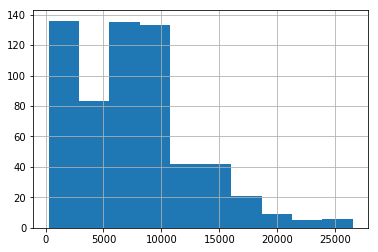

In [11]:
# We see a very large difference in cell count across profiles
# Remember that profiles were generated from averaging feature values for all single cells
all_datasets_df.Metadata_cell_count.hist()

In [12]:
# Reorder features
common_metadata = infer_cp_features(all_datasets_df, metadata=True)
morph_features = infer_cp_features(all_datasets_df)

all_datasets_df = all_datasets_df.reindex(common_metadata + morph_features, axis="columns")

print(all_datasets_df.shape)
all_datasets_df.head()

(612, 3548)


,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_clone_number,Metadata_plate_map_name,Metadata_treatment,Metadata_dataset,Metadata_clone_type,Metadata_clone_type_indicator,...,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_20_00,Nuclei_Texture_Variance_RNA_20_01,Nuclei_Texture_Variance_RNA_20_02,Nuclei_Texture_Variance_RNA_20_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
0,HCT116bortezomib,B03,2019_02_15_Batch1_20X,16508,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,-0.793648,-0.797138,-0.849765,-0.842252,-0.837198,-0.836068,-0.791112,-0.792191,-0.792930,-0.794808
1,HCT116bortezomib,B04,2019_02_15_Batch1_20X,15536,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,-0.614666,-0.621140,-0.668123,-0.648263,-0.664515,-0.663087,-0.608437,-0.612489,-0.609940,-0.612643
2,HCT116bortezomib,B05,2019_02_15_Batch1_20X,13969,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,-0.721152,-0.726177,-0.733418,-0.704771,-0.727368,-0.721084,-0.716559,-0.719909,-0.722098,-0.721685
3,HCT116bortezomib,B06,2019_02_15_Batch1_20X,13101,CloneA,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,resistant,1,...,-0.942861,-0.942481,-0.969639,-0.983566,-0.949551,-0.957997,-0.945461,-0.944792,-0.950591,-0.947476
4,HCT116bortezomib,B07,2019_02_15_Batch1_20X,13867,CloneA,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,resistant,1,...,-1.006237,-1.003932,-1.038378,-1.063397,-1.009417,-1.034740,-1.010104,-1.009058,-1.015389,-1.009931


## Apply feature selection

We apply feature selection per dataset using only the training set.
We track which features are selected per dataset and subset.

In [13]:
selected_features = []
for dataset in datasets:
        
    # Apply feature selection
    feature_select_df = feature_select(
        all_datasets_df.query("Metadata_dataset == @dataset").query("Metadata_model_split == 'training'"),
        operation=feature_select_opts,
        na_cutoff=na_cutoff,
    )

    dataset_features = infer_cp_features(feature_select_df)

    selected_features.append(
        pd.DataFrame(dataset_features, columns=["features"])
        .assign(dataset=dataset)
    )
    
# Output results of feature selection
all_selected_features = pd.concat(selected_features).reset_index(drop=True)

output_file = pathlib.Path(f"{output_dir}/dataset_features_selected.tsv")
all_selected_features.to_csv(output_file, sep="\t", index=False)

all_selected_features.head()

,features,dataset
0,Cells_AreaShape_Compactness,cloneAE
1,Cells_AreaShape_Extent,cloneAE
2,Cells_AreaShape_Orientation,cloneAE
3,Cells_AreaShape_Perimeter,cloneAE
4,Cells_AreaShape_Solidity,cloneAE


In [14]:
# How many features are selected?
all_selected_features.groupby("dataset")["features"].count()

dataset
cb5083      287
cloneAE     381
ixazomib    233
Name: features, dtype: int64

## Output Datasets

We output the feature selected datasets as .gct files, but the full feature set as compressed csvs.

In [15]:
output_file = pathlib.Path(f"{output_dir}/bulk_profiles_analytical_set.csv.gz")
output_gct_file = pathlib.Path(f"{output_dir}/bulk_profiles_feature_select_analytical_set.gct")
    
all_datasets_df.to_csv(output_file, sep=",", compression="gzip", index=False)

# Write the gct using selected features only
feature_selected_df = all_datasets_df.loc[:, common_metadata + all_selected_features.features.unique().tolist()]
write_gct(profiles=feature_selected_df, output_file=output_gct_file)

In [16]:
print(feature_selected_df.shape)
feature_selected_df.head()

(612, 624)


,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_clone_number,Metadata_plate_map_name,Metadata_treatment,Metadata_dataset,Metadata_clone_type,Metadata_clone_type_indicator,...,Nuclei_Texture_Correlation_Mito_5_01,Nuclei_Texture_Entropy_DNA_20_03,Nuclei_Texture_Entropy_Mito_20_01,Nuclei_Texture_Entropy_RNA_20_03,Nuclei_Texture_InfoMeas1_AGP_5_00,Nuclei_Texture_InfoMeas1_ER_5_02,Nuclei_Texture_InfoMeas1_Mito_5_02,Nuclei_Texture_InfoMeas2_Mito_5_00,Nuclei_Texture_SumVariance_AGP_20_03,Nuclei_Texture_SumVariance_DNA_20_01
0,HCT116bortezomib,B03,2019_02_15_Batch1_20X,16508,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,-0.514370,-1.811093,0.614945,-0.988485,0.796740,1.253760,0.582512,0.175965,-1.317654,-1.155140
1,HCT116bortezomib,B04,2019_02_15_Batch1_20X,15536,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,-0.456270,-1.104231,0.526220,-0.621441,0.957332,1.137343,0.527618,0.196673,-0.983245,-0.928489
2,HCT116bortezomib,B05,2019_02_15_Batch1_20X,13969,WT_parental,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,sensitive,0,...,-0.543658,-1.013741,0.426389,-0.644626,0.944409,0.901257,0.509450,0.026923,-0.665529,-0.910047
3,HCT116bortezomib,B06,2019_02_15_Batch1_20X,13101,CloneA,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,resistant,1,...,-0.616285,-1.082183,0.828704,-1.131617,1.338106,1.290009,0.500721,0.174048,-0.931321,-0.963639
4,HCT116bortezomib,B07,2019_02_15_Batch1_20X,13867,CloneA,PlateMap_HCT116bortezomib,0.1% DMSO,cloneAE,resistant,1,...,-0.809694,-0.979658,-0.111700,-1.503866,1.527541,1.418194,0.690725,-0.293653,-1.162307,-0.913635
